In [377]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *
import plotly.express as px
import pandas as pd
import numpy as np

In [3]:
def my_process_dataframe_timeline(args):
    """
    Massage input for bar traces for px.timeline()
    """
    print("my method")
    args["is_timeline"] = True
    if args["x_start"] is None or args["x_end"] is None:
        raise ValueError("Both x_start and x_end are required")

    x_start = args["data_frame"][args["x_start"]]
    x_end = args["data_frame"][args["x_end"]]

    # note that we are not adding any columns to the data frame here, so no risk of overwrite
    args["data_frame"][args["x_end"]] = (x_end - x_start)
    args["x"] = args["x_end"]
    del args["x_end"]
    args["base"] = args["x_start"]
    del args["x_start"]
    return args
px._core.process_dataframe_timeline = my_process_dataframe_timeline

In [607]:
import plotly.io as pio
pio.renderers.default='notebook'

### 1. MODA

模型列式：  
minimun energy: $$Min: c_{max} $$
minimun penalty: $$Min: TEC $$


In [449]:
def op_original(obj,new_v_list,new_lam_list,new_o_list):
    
    M = 3 # machine_num
    N = 6 # job_num

    p_dict = {}

    p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
    p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
    p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

    pi_dict = {}
    pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

    v_dict = {}
    lam_dict = {}
    v_dict[1], v_dict[2], v_dict[3] = new_v_list[0],new_v_list[1],new_v_list[2]
    lam_dict[1], lam_dict[2], lam_dict[3] = new_lam_list[0],new_lam_list[1],new_lam_list[2]
    B = 10**6
    time_list = []

    for i in range(3):
        time_list.append(new_o_list[i])

    x_dict = {}
    for i in range(M+1):
        for j in range(N+1):
            for k in range(N+1):
                        x_dict[(i,j,k)] = LpVariable("x"+str((i,j,k)),lowBound=0, upBound=1,cat="Binary")
    c_dict = {}
    for j in range(N+1):
        c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

    o_dict = {}
    for i in range(M+1):
        o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")

    c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
    TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

    problem = pulp.LpProblem("Mim energy",LpMinimize)
    if obj == 1:
        problem += c_max 
    elif obj ==2:
        problem += TEC
    for k in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for j in range(N+1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) == 1

    for j in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) <= 1

    for i in range(1,M+1,1):
        con_list = []
        for k in range(1,N+1,1):
                con_list.append(x_dict[(i,0,k)])
        problem += lpSum(con_list) <= 1

    for j in range(1,N+1,1):
        for i in range(1,M+1,1):
            sep_one_list = []
            sep_two_list = []
            for k in range(N+1):
                    if j != k:
                        sep_one_list.append(x_dict[(i,j,k)])
            for h in range(N+1):
                    if j != h:
                        sep_two_list.append(x_dict[(i,h,j)])   
            problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

    for i in range(1,M+1,1):
            for j in range(N+1):
                for k in range(1,N+1,+1):
                    if j != k:
                        problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k)]) >= (p_dict[(i,k)] / v_dict[i]) 

    problem += c_dict[0] == 0

    ####################################################################################
    ## new_o
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)] ])
        problem += lpSum(con_list) + time_list[i-1] == o_dict[i]
    ####################################################################################
    ## new_v
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]) * x_dict[(i,j,k)] ])
        sep_sum = 0
        for key, val in p_dict.items():
            if key[0] == i:
                sep_sum += val   
        problem += 1-lpSum(con_list)/sep_sum  == new_v_dict[i]    
    #####################################################################################

    for i in range(1,M+1,1):
        problem += c_max >= o_dict[i]

    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC


    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC

    solution = problem.solve()
    return value(TEC)

In [605]:
def op_original_c(obj,new_v_list,new_lam_list,new_o_list):
    
    M = 3 # machine_num
    N = 6 # job_num

    p_dict = {}

    p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
    p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
    p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

    pi_dict = {}
    pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

    v_dict = {}
    lam_dict = {}
    v_dict[1], v_dict[2], v_dict[3] = new_v_list[0],new_v_list[1],new_v_list[2]
    lam_dict[1], lam_dict[2], lam_dict[3] = new_lam_list[0],new_lam_list[1],new_lam_list[2]
    B = 10**6
    time_list = []

    for i in range(3):
        time_list.append(new_o_list[i])

    x_dict = {}
    for i in range(M+1):
        for j in range(N+1):
            for k in range(N+1):
                        x_dict[(i,j,k)] = LpVariable("x"+str((i,j,k)),lowBound=0, upBound=1,cat="Binary")
    c_dict = {}
    for j in range(N+1):
        c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

    o_dict = {}
    for i in range(M+1):
        o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")

    c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
    TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

    problem = pulp.LpProblem("Mim energy",LpMinimize)
    if obj == 1:
        problem += c_max 
    elif obj ==2:
        problem += TEC
    for k in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for j in range(N+1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) == 1

    for j in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) <= 1

    for i in range(1,M+1,1):
        con_list = []
        for k in range(1,N+1,1):
                con_list.append(x_dict[(i,0,k)])
        problem += lpSum(con_list) <= 1

    for j in range(1,N+1,1):
        for i in range(1,M+1,1):
            sep_one_list = []
            sep_two_list = []
            for k in range(N+1):
                    if j != k:
                        sep_one_list.append(x_dict[(i,j,k)])
            for h in range(N+1):
                    if j != h:
                        sep_two_list.append(x_dict[(i,h,j)])   
            problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

    for i in range(1,M+1,1):
            for j in range(N+1):
                for k in range(1,N+1,+1):
                    if j != k:
                        problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k)]) >= (p_dict[(i,k)] / v_dict[i]) 

    problem += c_dict[0] == 0

    ####################################################################################
    ## new_o
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)] ])
        problem += lpSum(con_list) + time_list[i-1] == o_dict[i]
    ####################################################################################
    ## new_v
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]) * x_dict[(i,j,k)] ])
        sep_sum = 0
        for key, val in p_dict.items():
            if key[0] == i:
                sep_sum += val   
        problem += 1-lpSum(con_list)/sep_sum  == new_v_dict[i]    
    #####################################################################################

    for i in range(1,M+1,1):
        problem += c_max >= o_dict[i]

    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC


    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC

    solution = problem.solve()
    return value(c_max)

In [601]:
p1 = 0.1
p2 = 1
q1 = 0.1
new_v = []
for q in np.arange(0,1,0.01):
    if q >= q1:
        new_v.append(p2 - (p2-p1)*(((q1-q)**2) / (1-q1)**2))
    else:
        new_v.append(1)

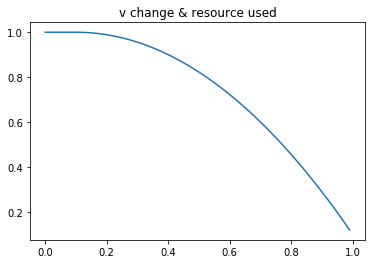

In [602]:
plt.title("v change & resource used")
plt.plot(np.arange(0,1,0.01),new_v)

In [598]:
def v_tran(q):
    p1 = 0.1
    p2 = 1
    q1 = 0.1
    new_v = []
    if q >= q1:
        return p2 - (p2-p1)*(((q1-q)**2) / (1-q1)**2)
    else:
        return 1

In [599]:
p1 = 10
p2 = 1
q1 = 0.1
new_v = []
for q in np.arange(0,1,0.01):
    if q >= q1:
        new_v.append(p2 + (p1-p2)*(((q1-q)**2) / (1-q1)**2))
    else:
        new_v.append(1)

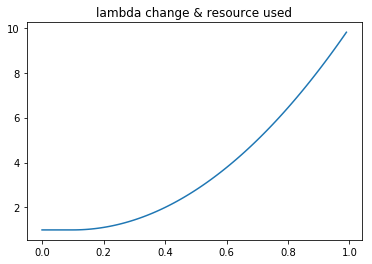

In [600]:
plt.title("lambda change & resource used")
plt.plot(np.arange(0,1,0.01),new_v)

In [597]:
def lam_tran(q):
    p1 = 10
    p2 = 1
    q1 = 0.1
    new_v = []
    if q >= q1:
        return p2 + (p1-p2)*(((q1-q)**2) / (1-q1)**2)
    else:
        return 1

### STEP MIN c_max

In [603]:
new_v_list = [1,1,1]
new_lam_list = [1,1,1]
new_o_list = [0,0,0]

for index in range(8):

    M = 3 # machine_num
    N = 6 # job_num

    p_dict = {}

    p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
    p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
    p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

    pi_dict = {}
    pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

    v_dict = {}
    lam_dict = {}
    v_dict[1], v_dict[2], v_dict[3] = new_v_list[0],new_v_list[1],new_v_list[2]
    lam_dict[1], lam_dict[2], lam_dict[3] = new_lam_list[0],new_lam_list[1],new_lam_list[2]
    B = 10**6
    time_list = []

    for i in range(3):
        time_list.append(new_o_list[i])

    x_dict = {}
    for i in range(M+1):
        for j in range(N+1):
            for k in range(N+1):
                        x_dict[(i,j,k)] = LpVariable("x"+str((i,j,k)),lowBound=0, upBound=1,cat="Binary")
    c_dict = {}
    for j in range(N+1):
        c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

    o_dict = {}
    for i in range(M+1):
        o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")
    ###########    
    new_resource_dict = {}
    for i in range(M+1):
        new_resource_dict[(i)] = LpVariable("new"+str(i),lowBound=0,cat="Continuous")
    ###########    
    c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
    TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

    problem = pulp.LpProblem("Mim energy",LpMinimize)
    problem += c_max 
    ###################################################################################################
    problem += TEC <= (op_original(1,new_v_list,new_lam_list,new_o_list) + op_original(2,new_v_list,new_lam_list,new_o_list))*0.5
    ###################################################################################################
    for k in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for j in range(N+1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) == 1

    for j in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) <= 1

    for i in range(1,M+1,1):
        con_list = []
        for k in range(1,N+1,1):
                con_list.append(x_dict[(i,0,k)])
        problem += lpSum(con_list) <= 1

    for j in range(1,N+1,1):
        for i in range(1,M+1,1):
            sep_one_list = []
            sep_two_list = []
            for k in range(N+1):
                    if j != k:
                        sep_one_list.append(x_dict[(i,j,k)])
            for h in range(N+1):
                    if j != h:
                        sep_two_list.append(x_dict[(i,h,j)])   
            problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

    for i in range(1,M+1,1):
            for j in range(N+1):
                for k in range(1,N+1,+1):
                    if j != k:
                        problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k)]) >= (p_dict[(i,k)] / v_dict[i]) 

    problem += c_dict[0] == 0

    ####################################################################################
    ## new_o
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)] ])
        problem += lpSum(con_list) + new_o_list[i-1] == o_dict[i]
    ####################################################################################
    ## new_resource_used
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]) * x_dict[(i,j,k)] ])
        sep_sum = 0
        for key, val in p_dict.items():
            if key[0] == i:
                sep_sum += val   
        problem += (lpSum(con_list)+new_o_list[i-1])/(sep_sum*(index+1))  == new_resource_dict[i]    
    #####################################################################################

    for i in range(1,M+1,1):
        problem += c_max >= o_dict[i]

    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC


    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC

    solution = problem.solve()
    print(value(c_max),value(TEC))


    j_loc = {}
    for v in problem.variables():
        if v.varValue == 1:
            if "new" not in v.name:
                if v.name[-2] != "0":
                    j_loc[int(v.name[-2])] = int(v.name[2])

    m_loc = {}
    for i in range(1,M+1,1):
        pair_loc = {}
        for v in problem.variables():
            if v.varValue == 1:
                if v.name[-2] != "0":
                    if "new" not in v.name:
                        if v.name[2] == str(i):
                            pair_loc[int(v.name[5])] = int(v.name[-2])
        sort_job = []
        sep = 0
        while (len(sort_job) < len(pair_loc)):
            for key, val in pair_loc.items():
                if key == sep:
                    sep = val
                    sort_job.append(val)
        m_loc[i] = sort_job



    c_loc = []
    for v in problem.variables():
        if "c" in v.name:
            if v.name == "c0" or v.name == "c_max":
                continue
            c_loc.append(v.varValue)

    j_m = []
    for i in range(1,N+1,1):
        j_m.append(str(j_loc[i]))
    job_name = []
    for i in range(1,N+1,1):
        job_name.append("JOB"+str(i))
    start_loc = {}
    for key, v in m_loc.items():
        for j in v:
            if v.index(j) == 0:
                start_loc[j] = 0
            else:
                start_loc[j] = c_loc[sep-1]
            sep = j       
    start_list = []
    for i in range(1,N+1,1):
        start_list.append(start_loc[i])

    for i in range(1,4,1):
        job_name.append("OLD_JOB")
        start_list.append(0)
        c_loc.append(new_o_list[i-1])
        j_m.append(str(i))

    df = pd.DataFrame()
    df["Task"] = job_name
    df["Start"] = start_list
    df["Finish"] = c_loc
    df["Machine"] = j_m
    df['delta'] = df['Finish'] - df['Start']

    for i in range(1,M+1,1): 
        df.loc[df["Machine"]==str(i) ,["Start","Finish"]] = df.loc[df["Machine"]==str(i),["Start","Finish"]] +new_o_list[i-1]

    for i in range(1,M+1,1): 
        df.loc[N+i-1,["Start","Finish"]] = df.loc[N+i-1,["Start","Finish"]] - new_o_list[i-1] 

    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Machine", color="Task",text="Task")
    fig.update_yaxes(autorange="reversed") 

    fig.layout.xaxis.type = 'linear'
    fig.data[0].x = df.delta.tolist() 
    fig.show()

    new_v_list = []
    for v in problem.variables():
        if "new"in v.name:
            print(v.name, "=", v.varValue)
    for v in problem.variables():
        if "new"in v.name:
            new_v_list.append(v_tran(v.varValue))
            print("Tran v",v.name, "=", v_tran(v.varValue))
    new_lam_list = []
    for v in problem.variables():
        if "new"in v.name:
            new_lam_list.append(lam_tran(v.varValue))
            print("Tran lam",v.name, "=", lam_tran(v.varValue))
    new_o_list = []
    for v in problem.variables():
        if "o"in v.name:
            print(v.name, "=", v.varValue)
            new_o_list.append(v.varValue)

9.0 162.0
my method


new1 = 0.3
new2 = 0.23076923
new3 = 0.21428571
Tran v new1 = 0.9555555555555556
Tran v new2 = 0.9809993427613413
Tran v new3 = 0.9854875294331066
Tran lam new1 = 1.4444444444444444
Tran lam new2 = 1.1900065723865878
Tran lam new3 = 1.1451247056689344
o1 = 9.0
o2 = 6.0
o3 = 6.0
18.418605 213.40472
my method


new1 = 0.3
new2 = 0.19230769
new3 = 0.25
Tran v new1 = 0.9555555555555556
Tran v new2 = 0.990532544852071
Tran v new3 = 0.975
Tran lam new1 = 1.4444444444444444
Tran lam new2 = 1.09467455147929
Tran lam new3 = 1.25
o1 = 18.418605
o2 = 10.077475
o3 = 14.117809
26.790698 214.01573
my method


new1 = 0.29354006
new2 = 0.3343266
new3 = 0.16806915
Tran v new1 = 0.9583802724168848
Tran v new2 = 0.9389900494804889
Tran v new3 = 0.9948517675758639
Tran lam new1 = 1.4161972758311512
Tran lam new2 = 1.610099505195111
Tran lam new3 = 1.0514823242413611
o1 = 26.790698
o2 = 26.230402
o3 = 14.117809
36.181542 219.22047
my method


new1 = 0.29825582
new2 = 0.29067694
new3 = 0.19748044
Tran v new1 = 0.9563273664845863
Tran v new2 = 0.9596025606135961
Tran v new3 = 0.989441737574896
Tran lam new1 = 1.4367263351541377
Tran lam new2 = 1.4039743938640399
Tran lam new3 = 1.10558262425104
o1 = 36.181542
o2 = 30.490298
o3 = 22.159208
45.592545 218.39682
my method


new1 = 0.30121028
new2 = 0.2806946
new3 = 0.2011372
Tran v new1 = 0.9550160258025796
Tran v new2 = 0.9637216239231555
Tran v new3 = 0.9886347408624
Tran lam new1 = 1.4498397419742044
Tran lam new2 = 1.3627837607684445
Tran lam new3 = 1.113652591376
o1 = 45.592545
o2 = 36.742887
o3 = 28.223234
50.828059 248.4021
my method


new1 = 0.28106969
new2 = 0.24835184
new3 = 0.26323354
Tran v new1 = 0.9635708526258933
Tran v new2 = 0.9755463684095715
Tran v new3 = 0.970394234910076
Tran lam new1 = 1.3642914737410676
Tran lam new2 = 1.2445363159042844
Tran lam new3 = 1.29605765089924
o1 = 50.828059
o2 = 38.818175
o3 = 44.407169
60.168317 209.13319
my method


new1 = 0.28489552
new2 = 0.28471525
new3 = 0.22656719
Tran v new1 = 0.962015162982144
Tran v new2 = 0.962089196019375
Tran v new3 = 0.9822008293505599
Tran lam new1 = 1.37984837017856
Tran lam new2 = 1.3791080398062499
Tran lam new3 = 1.177991706494401
o1 = 60.168317
o2 = 52.144041
o3 = 44.407169
67.44471 246.87835
my method


new1 = 0.27986799
new2 = 0.29876943
new3 = 0.225032
Tran v new1 = 0.9640527846370666
Tran v new2 = 0.9561007929971945
Tran v new3 = 0.9826299988622222
Tran lam new1 = 1.3594721536293344
Tran lam new2 = 1.4389920700280543
Tran lam new3 = 1.1737000113777778
o1 = 67.44471
o2 = 62.538088
o3 = 50.515899


### STEP MIN TEC

In [606]:
new_v_list = [1,1,1]
new_lam_list = [1,1,1]
new_o_list = [0,0,0]

for index in range(8):

    M = 3 # machine_num
    N = 6 # job_num

    p_dict = {}

    p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
    p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
    p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

    pi_dict = {}
    pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

    v_dict = {}
    lam_dict = {}
    v_dict[1], v_dict[2], v_dict[3] = new_v_list[0],new_v_list[1],new_v_list[2]
    lam_dict[1], lam_dict[2], lam_dict[3] = new_lam_list[0],new_lam_list[1],new_lam_list[2]
    B = 10**6
    time_list = []

    for i in range(3):
        time_list.append(new_o_list[i])

    x_dict = {}
    for i in range(M+1):
        for j in range(N+1):
            for k in range(N+1):
                        x_dict[(i,j,k)] = LpVariable("x"+str((i,j,k)),lowBound=0, upBound=1,cat="Binary")
    c_dict = {}
    for j in range(N+1):
        c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

    o_dict = {}
    for i in range(M+1):
        o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")
    ###########    
    new_resource_dict = {}
    for i in range(M+1):
        new_resource_dict[(i)] = LpVariable("new"+str(i),lowBound=0,cat="Continuous")
    ###########    
    c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
    TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

    problem = pulp.LpProblem("Mim energy",LpMinimize)
    problem += TEC 
    ###################################################################################################
    problem += c_max <= (op_original_c(1,new_v_list,new_lam_list,new_o_list) + op_original_c(2,new_v_list,new_lam_list,new_o_list))*0.5
    ###################################################################################################
    for k in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for j in range(N+1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) == 1

    for j in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k)])
        problem += lpSum(con_list) <= 1

    for i in range(1,M+1,1):
        con_list = []
        for k in range(1,N+1,1):
                con_list.append(x_dict[(i,0,k)])
        problem += lpSum(con_list) <= 1

    for j in range(1,N+1,1):
        for i in range(1,M+1,1):
            sep_one_list = []
            sep_two_list = []
            for k in range(N+1):
                    if j != k:
                        sep_one_list.append(x_dict[(i,j,k)])
            for h in range(N+1):
                    if j != h:
                        sep_two_list.append(x_dict[(i,h,j)])   
            problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

    for i in range(1,M+1,1):
            for j in range(N+1):
                for k in range(1,N+1,+1):
                    if j != k:
                        problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k)]) >= (p_dict[(i,k)] / v_dict[i]) 

    problem += c_dict[0] == 0

    ####################################################################################
    ## new_o
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)] ])
        problem += lpSum(con_list) + new_o_list[i-1] == o_dict[i]
    ####################################################################################
    ## new_resource_used
    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]) * x_dict[(i,j,k)] ])
        sep_sum = 0
        for key, val in p_dict.items():
            if key[0] == i:
                sep_sum += val   
        problem += (lpSum(con_list)+new_o_list[i-1])/(sep_sum*(index+1))  == new_resource_dict[i]    
    #####################################################################################

    for i in range(1,M+1,1):
        problem += c_max >= o_dict[i]

    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC


    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[i]*pi_dict[i]*p_dict[(i,k)]/v_dict[i]) * x_dict[(i,j,k)]  ])
    problem += lpSum(con_list) <= TEC

    solution = problem.solve()
    print(value(c_max),value(TEC))


    j_loc = {}
    for v in problem.variables():
        if v.varValue == 1:
            if "new" not in v.name:
                if v.name[-2] != "0":
                    j_loc[int(v.name[-2])] = int(v.name[2])

    m_loc = {}
    for i in range(1,M+1,1):
        pair_loc = {}
        for v in problem.variables():
            if v.varValue == 1:
                if v.name[-2] != "0":
                    if "new" not in v.name:
                        if v.name[2] == str(i):
                            pair_loc[int(v.name[5])] = int(v.name[-2])
        sort_job = []
        sep = 0
        while (len(sort_job) < len(pair_loc)):
            for key, val in pair_loc.items():
                if key == sep:
                    sep = val
                    sort_job.append(val)
        m_loc[i] = sort_job



    c_loc = []
    for v in problem.variables():
        if "c" in v.name:
            if v.name == "c0" or v.name == "c_max":
                continue
            c_loc.append(v.varValue)

    j_m = []
    for i in range(1,N+1,1):
        j_m.append(str(j_loc[i]))
    job_name = []
    for i in range(1,N+1,1):
        job_name.append("JOB"+str(i))
    start_loc = {}
    for key, v in m_loc.items():
        for j in v:
            if v.index(j) == 0:
                start_loc[j] = 0
            else:
                start_loc[j] = c_loc[sep-1]
            sep = j       
    start_list = []
    for i in range(1,N+1,1):
        start_list.append(start_loc[i])

    for i in range(1,4,1):
        job_name.append("OLD_JOB")
        start_list.append(0)
        c_loc.append(new_o_list[i-1])
        j_m.append(str(i))

    df = pd.DataFrame()
    df["Task"] = job_name
    df["Start"] = start_list
    df["Finish"] = c_loc
    df["Machine"] = j_m
    df['delta'] = df['Finish'] - df['Start']

    for i in range(1,M+1,1): 
        df.loc[df["Machine"]==str(i) ,["Start","Finish"]] = df.loc[df["Machine"]==str(i),["Start","Finish"]] +new_o_list[i-1]

    for i in range(1,M+1,1): 
        df.loc[N+i-1,["Start","Finish"]] = df.loc[N+i-1,["Start","Finish"]] - new_o_list[i-1] 

    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Machine", color="Task",text="Task")
    fig.update_yaxes(autorange="reversed") 

    fig.layout.xaxis.type = 'linear'
    fig.data[0].x = df.delta.tolist() 
    fig.show()

    new_v_list = []
    for v in problem.variables():
        if "new"in v.name:
            print(v.name, "=", v.varValue)
    for v in problem.variables():
        if "new"in v.name:
            new_v_list.append(v_tran(v.varValue))
            print("Tran v",v.name, "=", v_tran(v.varValue))
    new_lam_list = []
    for v in problem.variables():
        if "new"in v.name:
            new_lam_list.append(lam_tran(v.varValue))
            print("Tran lam",v.name, "=", lam_tran(v.varValue))
    new_o_list = []
    for v in problem.variables():
        if "o"in v.name:
            print(v.name, "=", v.varValue)
            new_o_list.append(v.varValue)

D:\anaconda\lib\site-packages\pulp\pulp.py:1199: UserWarning:

Spaces are not permitted in the name. Converted to '_'



11.5 154.0
my method


new1 = 0.36666667
new2 = 0.42307692
new3 = 0.0
Tran v new1 = 0.920987652345679
Tran v new2 = 0.8840236708481262
Tran v new3 = 1
Tran lam new1 = 1.79012347654321
Tran lam new2 = 2.159763291518738
Tran lam new3 = 1
o1 = 11.0
o2 = 11.0
o3 = 0.0
18.386059 254.07629
my method


new1 = 0.23333333
new2 = 0.25
new3 = 0.32142857
Tran v new1 = 0.9802469145679013
Tran v new2 = 0.975
Tran v new3 = 0.9455215426530612
Tran lam new1 = 1.1975308543209877
Tran lam new2 = 1.25
Tran lam new3 = 1.544784573469388
o1 = 14.257373
o2 = 13.262383
o3 = 18.0
26.499187 193.45023
my method


new1 = 0.28063748
new2 = 0.31105619
new3 = 0.21428571
Tran v new1 = 0.9637445564658329
Tran v new2 = 0.9505058718474265
Tran v new3 = 0.9854875294331066
Tran lam new1 = 1.362554435341671
Tran lam new2 = 1.4949412815257346
Tran lam new3 = 1.1451247056689344
o1 = 25.479035
o2 = 24.544434
o3 = 18.0
35.950093 217.70925
my method


new1 = 0.28732529
new2 = 0.25523494
new3 = 0.25
Tran v new1 = 0.9610102619182399
Tran v new2 = 0.973224570447996
Tran v new3 = 0.975
Tran lam new1 = 1.3898973808176012
Tran lam new2 = 1.26775429552004
Tran lam new3 = 1.25
o1 = 34.817609
o2 = 26.648577
o3 = 28.147262
44.414928 212.75009
my method


new1 = 0.29211739
new2 = 0.26652752
new3 = 0.2296233
Tran v new1 = 0.9589898982884311
Tran v new2 = 0.9691873167584996
Tran v new3 = 0.9813308889967889
Tran lam new1 = 1.4101010171156898
Tran lam new2 = 1.3081268324150044
Tran lam new3 = 1.1866911100321111
o1 = 44.182754
o2 = 34.868674
o3 = 32.249826
53.046247 237.72493
my method


new1 = 0.28990419
new2 = 0.29402996
new3 = 0.21577277
Tran v new1 = 0.9599293318004932
Tran v new2 = 0.9581693051359982
Tran v new3 = 0.9851074063628079
Tran lam new1 = 1.4007066819950678
Tran lam new2 = 1.4183069486400177
Tran lam new3 = 1.148925936371921
o1 = 52.524865
o2 = 46.218389
o3 = 36.325923
61.374528 246.23674
my method


new1 = 0.28821364
new2 = 0.29240873
new3 = 0.22615267
Tran v new1 = 0.960639584131056
Tran v new2 = 0.9588654229108745
Tran v new3 = 0.982317226502079
Tran lam new1 = 1.3936041586894399
Tran lam new2 = 1.4113457708912545
Tran lam new3 = 1.17682773497921
o1 = 60.858812
o2 = 53.523987
o3 = 44.446865
69.622146 247.08074
my method


new1 = 0.28691172
new2 = 0.31021148
new3 = 0.21628065
Tran v new1 = 0.9611822321407129
Tran v new2 = 0.9509012596402329
Tran v new3 = 0.9849764560395305
Tran lam new1 = 1.388177678592871
Tran lam new2 = 1.490987403597671
Tran lam new3 = 1.1502354396046943
o1 = 69.186597
o2 = 64.995878
o3 = 48.518869


### 下面是上次的結果 :D

### MIN C_MAX

In [329]:
M = 3 # machine_num
N = 6 # job_num
L = 3 # mode (corresponding speed & power)

p_dict = {}

p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

pi_dict = {}
pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

v_dict = {}
lam_dict = {}
v_dict[1], v_dict[2], v_dict[3] = 1, 1, 1
lam_dict[1], lam_dict[2], lam_dict[3] = 1, 1, 1
B = 10**6

x_dict = {}
for i in range(M+1):
    for j in range(N+1):
        for k in range(N+1):
            for l in range(L+1):
                    x_dict[(i,j,k,l)] = LpVariable("x"+str((i,j,k,l)),lowBound=0, upBound=1,cat="Binary")
c_dict = {}
for j in range(N+1):
    c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

o_dict = {}
for i in range(M+1):
    o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")

c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

problem = pulp.LpProblem("Mim energy",LpMinimize)
problem += TEC 

for k in range(1,N+1,1):
    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append(x_dict[(i,j,k,l)])
    problem += lpSum(con_list) == 1

for j in range(1,N+1,1):
    con_list = []
    for i in range(1,M+1,1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append(x_dict[(i,j,k,l)])
    problem += lpSum(con_list) <= 1

for i in range(1,M+1,1):
    con_list = []
    for k in range(1,N+1,1):
        for l in range(1,L+1,1):
            con_list.append(x_dict[(i,0,k,l)])
    problem += lpSum(con_list) <= 1

for j in range(1,N+1,1):
    for i in range(1,M+1,1):
        sep_one_list = []
        sep_two_list = []
        for k in range(N+1):
            for l in range(1,L+1,1):
                if j != k:
                    sep_one_list.append(x_dict[(i,j,k,l)])
        for h in range(N+1):
            for l in range(1,L+1,1):
                if j != h:
                    sep_two_list.append(x_dict[(i,h,j,l)])   
        problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

for i in range(1,M+1,1):
    for l in range(1,L+1,1):
        for j in range(N+1):
            for k in range(1,N+1,+1):
                if j != k:
                    problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k,l)]) >= (p_dict[(i,k)] / v_dict[l]) 
                    
problem += c_dict[0] == 0


for i in range(1,M+1,1):
    con_list = []
    for j in range(N+1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append([ (p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)] ])
    problem += lpSum(con_list) == o_dict[i]
####################################################################################
## new_v
for i in range(1,M+1,1):
    con_list = []
    for j in range(N+1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append([ (p_dict[(i,k)]) * x_dict[(i,j,k,l)] ])
    sep_sum = 0
    for key, val in p_dict.items():
        if key[0] == i:
            sep_sum += val   
    problem += 1-lpSum(con_list)/sep_sum  == new_v_dict[i]    
    
for i in range(1,M+1,1):
    problem += c_max >= o_dict[i]

    
con_list = []
for i in range(1,M+1,1):
    for j in range(N+1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append([ (lam_dict[l]*pi_dict[i]*p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)]  ])
problem += lpSum(con_list) <= TEC
    
con_list = []
for i in range(1,M+1,1):
    for j in range(N+1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append([ (lam_dict[l]*pi_dict[i]*p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)]  ])
problem += lpSum(con_list) <= TEC

solution = problem.solve()
        
j_loc = {}
mode_loc = {}
for v in problem.variables():
    if v.varValue == 1:
        if "new" not in v.name:
            if v.name[-5] != "0":
                j_loc[int(v.name[-5])] = int(v.name[2])
                mode_loc[int(v.name[-5])] = int(v.name[-2])

m_loc = {}
for i in range(1,M+1,1):
    pair_loc = {}
    for v in problem.variables():
        if v.varValue == 1:
            if v.name[-5] != "0":
                if v.name[2] == str(i):
                    pair_loc[int(v.name[-8])] = int(v.name[-5])
    sort_job = []
    sep = 0
    while (len(sort_job) < len(pair_loc)):
        for key, v in pair_loc.items():
            if key == sep:
                sep = v
                sort_job.append(v)
    m_loc[i] = sort_job
    
mode_list = []
for i in range(1,N+1,1):
    mode_list.append(mode_loc[i])
    
c_loc = []
for v in problem.variables():
    if "c" in v.name:
        if v.name == "c0" or v.name == "c_max":
            continue
        c_loc.append(v.varValue)
j_m = []
for i in range(1,N+1,1):
    j_m.append(str(j_loc[i]))
job_name = []
for i in range(1,N+1,1):
    job_name.append("JOB"+str(i)+str("_m")+str(mode_list[i-1]))
start_loc = {}
for key, v in m_loc.items():
    for j in v:
        if v.index(j) == 0:
            start_loc[j] = 0
        else:
            start_loc[j] = c_loc[sep-1]
        sep = j       
start_list = []
for i in range(1,N+1,1):
    start_list.append(start_loc[i])
df = pd.DataFrame()
df["Task"] = job_name
df["Start"] = start_list
df["Finish"] = c_loc
df["Machine"] = j_m
df['delta'] = df['Finish'] - df['Start']

fig = px.timeline(df, x_start="Start", x_end="Finish", y="Machine", color="Task",text="Task")
fig.update_yaxes(autorange="reversed") 

fig.layout.xaxis.type = 'linear'
fig.data[0].x = df.delta.tolist() 
fig.show()

print(value(c_max),value(TEC))
new_v_list = []
for v in problem.variables():
    if "new_v"in v.name:
        print(v.name, "=", v.varValue)
        new_v_list.append(v.varValue)
new_o_list = []
for v in problem.variables():
    if "o"in v.name:
        print(v.name, "=", v.varValue)
        new_o_list.append(v.varValue)

my method


15.0 146.0
new_v1 = 0.5
new_v2 = 0.73076923
new_v3 = 1.0
o1 = 15.0
o2 = 7.0
o3 = 0.0


### MIN TEC

In [122]:
M = 3 # machine_num
N = 6 # job_num
L = 3 # mode (corresponding speed & power)

p_dict = {}

p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

pi_dict = {}
pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

v_dict = {}
lam_dict = {}
v_dict[1], v_dict[2], v_dict[3] = 1, 1, 1
lam_dict[1], lam_dict[2], lam_dict[3] = 1, 1, 1
B = 10**6

x_dict = {}
for i in range(M+1):
    for j in range(N+1):
        for k in range(N+1):
            for l in range(L+1):
                    x_dict[(i,j,k,l)] = LpVariable("x"+str((i,j,k,l)),lowBound=0, upBound=1,cat="Binary")
c_dict = {}
for j in range(N+1):
    c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

o_dict = {}
for i in range(M+1):
    o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")

c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

problem = pulp.LpProblem("Mim energy",LpMinimize)
problem += TEC 

for k in range(1,N+1,1):
    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append(x_dict[(i,j,k,l)])
    problem += lpSum(con_list) == 1

for j in range(1,N+1,1):
    con_list = []
    for i in range(1,M+1,1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append(x_dict[(i,j,k,l)])
    problem += lpSum(con_list) <= 1

for i in range(1,M+1,1):
    con_list = []
    for k in range(1,N+1,1):
        for l in range(1,L+1,1):
            con_list.append(x_dict[(i,0,k,l)])
    problem += lpSum(con_list) <= 1

for j in range(1,N+1,1):
    for i in range(1,M+1,1):
        sep_one_list = []
        sep_two_list = []
        for k in range(N+1):
            for l in range(1,L+1,1):
                if j != k:
                    sep_one_list.append(x_dict[(i,j,k,l)])
        for h in range(N+1):
            for l in range(1,L+1,1):
                if j != h:
                    sep_two_list.append(x_dict[(i,h,j,l)])   
        problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

for i in range(1,M+1,1):
    for l in range(1,L+1,1):
        for j in range(N+1):
            for k in range(1,N+1,+1):
                if j != k:
                    problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k,l)]) >= (p_dict[(i,k)] / v_dict[l]) 
                    
problem += c_dict[0] == 0


for i in range(1,M+1,1):
    con_list = []
    for j in range(N+1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append([ (p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)] ])
    problem += lpSum(con_list) == o_dict[i]

for i in range(1,M+1,1):
    problem += c_max >= o_dict[i]

con_list = []
for i in range(1,M+1,1):
    for j in range(N+1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append([ (lam_dict[l]*pi_dict[i]*p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)]  ])
problem += lpSum(con_list) <= TEC

    
con_list = []
for i in range(1,M+1,1):
    for j in range(N+1):
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                if j != k:
                    con_list.append([ (lam_dict[l]*pi_dict[i]*p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)]  ])
problem += lpSum(con_list) <= TEC

solution = problem.solve()
print(value(c_max),value(TEC))

15.0 146.0


### epision method

In [290]:
def op_job(ep):
    M = 3 # machine_num
    N = 6 # job_num
    L = 3 # mode (corresponding speed & power)

    p_dict = {}

    p_dict[(1,0)], p_dict[(1,1)], p_dict[(1,2)], p_dict[(1,3)], p_dict[(1,4)], p_dict[(1,5)], p_dict[(1,6)] =  0,3,6,4,7,8,2
    p_dict[(2,0)], p_dict[(2,1)], p_dict[(2,2)], p_dict[(2,3)], p_dict[(2,4)], p_dict[(2,5)], p_dict[(2,6)] =  0,5,8,4,5,2,2
    p_dict[(3,0)], p_dict[(3,1)], p_dict[(3,2)], p_dict[(3,3)], p_dict[(3,4)], p_dict[(3,5)], p_dict[(3,6)] =  0,7,8,4,4,3,2

    pi_dict = {}
    pi_dict[1], pi_dict[2], pi_dict[3] = 6,8,10

    v_dict = {}
    lam_dict = {}
    v_dict[1], v_dict[2], v_dict[3] = 1, 0.8, 1.2
    lam_dict[1], lam_dict[2], lam_dict[3] = 1, 0.8, 1.2
    B = 10**6

    x_dict = {}
    for i in range(M+1):
        for j in range(N+1):
            for k in range(N+1):
                for l in range(L+1):
                        x_dict[(i,j,k,l)] = LpVariable("x"+str((i,j,k,l)),lowBound=0, upBound=1,cat="Binary")
    c_dict = {}
    for j in range(N+1):
        c_dict[(j)] = LpVariable("c"+str(j),lowBound=0,cat="Continuous")                

    o_dict = {}
    for i in range(M+1):
        o_dict[(i)] = LpVariable("o"+str(i),lowBound=0,cat="Continuous")

    c_max = LpVariable("c_max",lowBound=0,cat="Continuous")
    TEC = LpVariable("TEC",lowBound=0,cat="Continuous")

    problem = pulp.LpProblem("Mim energy",LpMinimize)
    problem += c_max
    problem += TEC <= ep
    for k in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for j in range(N+1):
                for l in range(1,L+1,1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k,l)])
        problem += lpSum(con_list) == 1

    for j in range(1,N+1,1):
        con_list = []
        for i in range(1,M+1,1):
            for k in range(1,N+1,1):
                for l in range(1,L+1,1):
                    if j != k:
                        con_list.append(x_dict[(i,j,k,l)])
        problem += lpSum(con_list) <= 1

    for i in range(1,M+1,1):
        con_list = []
        for k in range(1,N+1,1):
            for l in range(1,L+1,1):
                con_list.append(x_dict[(i,0,k,l)])
        problem += lpSum(con_list) <= 1

    for j in range(1,N+1,1):
        for i in range(1,M+1,1):
            sep_one_list = []
            sep_two_list = []
            for k in range(N+1):
                for l in range(1,L+1,1):
                    if j != k:
                        sep_one_list.append(x_dict[(i,j,k,l)])
            for h in range(N+1):
                for l in range(1,L+1,1):
                    if j != h:
                        sep_two_list.append(x_dict[(i,h,j,l)])   
            problem += lpSum(sep_one_list) - lpSum(sep_two_list) == 0

    for i in range(1,M+1,1):
        for l in range(1,L+1,1):
            for j in range(N+1):
                for k in range(1,N+1,+1):
                    if j != k:
                        problem += c_dict[k] - c_dict[j] + B*(1-x_dict[(i,j,k,l)]) >= (p_dict[(i,k)] / v_dict[l]) 

    problem += c_dict[0] == 0


    for i in range(1,M+1,1):
        con_list = []
        for j in range(N+1):
            for k in range(1,N+1,1):
                for l in range(1,L+1,1):
                    if j != k:
                        con_list.append([ (p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)] ])
        problem += lpSum(con_list) == o_dict[i]

    for i in range(1,M+1,1):
        problem += c_max >= o_dict[i]

    con_list = []
    for i in range(1,M+1,1):
        for j in range(N+1):
            for k in range(1,N+1,1):
                for l in range(1,L+1,1):
                    if j != k:
                        con_list.append([ (lam_dict[l]*pi_dict[i]*p_dict[(i,k)]/v_dict[l]) * x_dict[(i,j,k,l)] ])
    problem += lpSum(con_list) <= TEC

    solution = problem.solve()
    print(value(c_max),value(TEC))

    j_loc = {}
    mode_loc = {}
    for v in problem.variables():
        if v.varValue == 1:
            if v.name[-5] != "0":
                j_loc[int(v.name[-5])] = int(v.name[2])
                mode_loc[int(v.name[-5])] = int(v.name[-2])

    m_loc = {}
    for i in range(1,M+1,1):
        pair_loc = {}
        for v in problem.variables():
            if v.varValue == 1:
                if v.name[-5] != "0":
                    if v.name[2] == str(i):
                        pair_loc[int(v.name[-8])] = int(v.name[-5])
        sort_job = []
        sep = 0
        while (len(sort_job) < len(pair_loc)):
            for key, v in pair_loc.items():
                if key == sep:
                    sep = v
                    sort_job.append(v)
        m_loc[i] = sort_job

    mode_list = []
    for i in range(1,N+1,1):
        mode_list.append(mode_loc[i])

    c_loc = []
    for v in problem.variables():
        if "c" in v.name:
            if v.name == "c0" or v.name == "c_max":
                continue
            c_loc.append(v.varValue)
    j_m = []
    for i in range(1,N+1,1):
        j_m.append(str(j_loc[i]))
    job_name = []
    for i in range(1,N+1,1):
        job_name.append("JOB"+str(i)+str("_m")+str(mode_list[i-1]))
    start_loc = {}
    for key, v in m_loc.items():
        for j in v:
            if v.index(j) == 0:
                start_loc[j] = 0
            else:

                start_loc[j] = c_loc[sep-1]
            sep = j       
    start_list = []
    for i in range(1,N+1,1):
        start_list.append(start_loc[i])

    df = pd.DataFrame()
    df["Task"] = job_name
    df["Start"] = start_list
    df["Finish"] = c_loc
    df["Machine"] = j_m
    df['delta'] = df['Finish'] - df['Start']

    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Machine", color="Task",text="Task")
    fig.update_yaxes(autorange="reversed") 

    fig.layout.xaxis.type = 'linear'
    fig.data[0].x = df.delta.tolist() 
    fig.show()
    return [value(c_max),value(TEC)]

### range 146~184

In [291]:
c_max_list = []
TEC_list = []
for i in list(range(146,184+2,2)):
    c_max_list.append(op_job(i)[0])
    TEC_list.append(op_job(i)[1])

12.5 146.0
my method


12.5 146.0
my method


12.5 146.0
my method


12.5 146.0
my method


10.833333 150.0
my method


10.833333 150.0
my method


10.833333 150.0
my method


10.833333 150.0
my method


9.1666667 154.0
my method


9.1666667 154.0
my method


9.1666667 154.0
my method


9.1666667 154.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 166.0
my method


7.5 166.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 158.0
my method


7.5 158.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 162.0
my method


7.5 162.0
my method


6.6666667 184.0
my method


6.6666667 184.0
my method


In [292]:
ep_df = pd.DataFrame()
ep_df["c_max"] = c_max_list
ep_df["TEC"] = TEC_list

In [293]:
ep_df

,c_max,TEC
0,12.500000,146.0
1,12.500000,146.0
2,10.833333,150.0
3,10.833333,150.0
4,9.166667,154.0
5,9.166667,154.0
6,7.500000,158.0
7,7.500000,158.0
8,7.500000,158.0
9,7.500000,158.0


Text(0, 0.5, 'TEC')

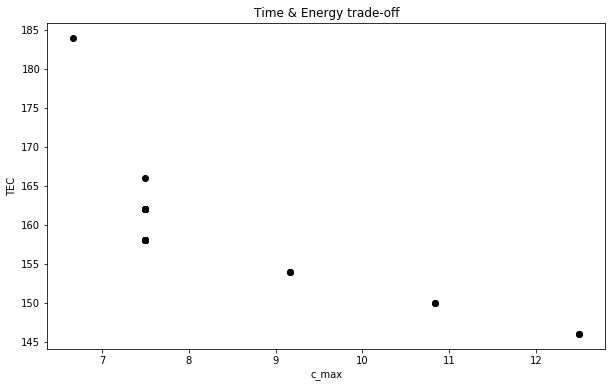

In [300]:
plt.figure(figsize=(10,6))
plt.title("Time & Energy trade-off")
plt.scatter(ep_df["c_max"],ep_df["TEC"],label="epision",color="black")
plt.xlabel("c_max")
plt.ylabel("TEC")